In [132]:
from biocrnpyler import *
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import lmfit
import numpy as np
import scipy.integrate as scint 
import matplotlib.pyplot as plt 
import pandas as pd
import random


from matplotlib import style
%config InlineBackend.figure_format = 'retina'

style.use("default")

%matplotlib inline

In [133]:
# Importing experimental data

geags_data = pd.read_csv("FL_by_OD_expt_data.csv")
time = geags_data["Time (min)"].to_numpy()
A1 = geags_data["A1"].to_numpy()
A2 = geags_data["A2"].to_numpy()
A3 = geags_data["A3"].to_numpy()
B1 = geags_data["B1"].to_numpy()
B2 = geags_data["B2"].to_numpy()
B3 = geags_data["B3"].to_numpy()

A12 = A1 - A1[0]
A1_non_leaky = A12[np.argwhere(A12 >= 0)]
t12 = time[len(A1_non_leaky) - 1]
time12 = np.linspace(0,t12,len(A1_non_leaky))

A22 = A2 - A2[0]
A2_non_leaky = A22[np.argwhere(A22 >= 0)]
t22 = time[len(A2_non_leaky) - 1]
time22 = np.linspace(0,t22,len(A2_non_leaky))

A32 = A3 - A3[0]
A3_non_leaky = A32[np.argwhere(A32 >= 0)]
t32 = time[len(A3_non_leaky) - 1]
time32 = np.linspace(0,t32,len(A3_non_leaky))

B12 = B1 - B1[0]
B1_non_leaky = B12[np.argwhere(B12 >= 0)]
tB12 = time[len(B1_non_leaky) - 1]
timeB12 = np.linspace(0,tB12,len(B1_non_leaky))

B22 = B2 - B2[0]
B2_non_leaky = B22[np.argwhere(B22 >= 0)]
tB22 = time[len(B2_non_leaky) - 1]
timeB22 = np.linspace(0,tB22,len(B2_non_leaky))

B32 = B3 - B3[0]
B3_non_leaky = B32[np.argwhere(B32 >= 0)]
tB32 = time[len(B3_non_leaky) - 1]
timeB32 = np.linspace(0,tB32,len(B3_non_leaky))

A_avg = (A1_non_leaky[:88] + A2_non_leaky[:88] + A3_non_leaky[:88])/3
B_avg = (B1_non_leaky[:88] + B2_non_leaky[:88] + B3_non_leaky[:88])/3
avg_fold_change = np.mean((np.max(B1_non_leaky)/np.max(A1_non_leaky),np.max(B2_non_leaky)/np.max(A2_non_leaky),np.max(B3_non_leaky)/np.max(A3_non_leaky)))
avg_fold_change

10.730826930616777

In [134]:
# Importing growth data
OD_data = pd.read_csv("expt_growth_data.csv")
time = OD_data["time(min)"].to_numpy()
OD_blank = 0.078*1
A1 = OD_data["A1"].to_numpy() - OD_blank
A2 = OD_data["A2"].to_numpy() - OD_blank
A3 = OD_data["A3"].to_numpy() - OD_blank
B1 = OD_data["B1"].to_numpy() - OD_blank
B2 = OD_data["B2"].to_numpy() - OD_blank
B3 = OD_data["B3"].to_numpy() - OD_blank

C_OD = 1e9
C1 = A1 * C_OD
C2 = A2 * C_OD
C3 = A3 * C_OD
C4 = B1 * C_OD
C5 = B2 * C_OD
C6 = B3 * C_OD

C1_max = np.max(C1)
C2_max = np.max(C2)
C3_max = np.max(C3)
C4_max = np.max(C4)
C5_max = np.max(C5)
C6_max = np.max(C6)
C_max = [C1_max, C2_max, C3_max, C4_max, C5_max, C6_max]

C1_0 = np.min(C1)
C2_0 = np.min(C2)
C3_0 = np.min(C3)
C4_0 = np.min(C4)
C5_0 = np.min(C5)
C6_0 = np.min(C6)
C_0 = [C1_0, C2_0, C3_0, C4_0, C5_0, C6_0]

k_gr = [0.01692117, 0.01527194, 0.01514989, 0.01656997, 0.01770599,
       0.01571999]
k_gr1 = k_gr[0]
k_gr2 = k_gr[1]
k_gr3 = k_gr[2]
k_gr4 = k_gr[3]
k_gr5 = k_gr[4]
k_gr6 = k_gr[5]

C_max_avg = np.mean(C_max[:3])
C_0_avg = np.mean(C_0[:3])
k_gr_avg = np.mean(k_gr[:3])

In [135]:
## Load the model and defining the timepoints

model_degtag = Model(sbml_filename = 'Biocrnpyler_model_degtag_030225.xml')
model_no_tag = Model(sbml_filename = 'Biocrnpyler_model_no_degtag_030225.xml')

N_steps = 1000
t_final = 1000
timepoints = np.linspace(0, t_final, N_steps)

tf_I = 720  # Time till we want to plot the simulation 
tf_i = 72   # Indice of the experimental data array till we want to plot the simulation

In [136]:
## Wrote a function to pass the parameters of the model 

def run_CRN_model(param, model_degtag, model_no_tag, timepoints): 

    params = param.valuesdict() # params is an LMFIT object so values of parameters are extracted as a dictinory 

    n = 5.5 # Fixed parameter

    model_degtag.set_species({'dna_X': 100,
    'protein_sigma_machinery': params['Sigma_IC'],
    'protein_NT_units': params['NT_IC'],
    'protein_AA_units0tl': params['AA_IC'],
    'protein_RNAase_machinery': params['RNAase_IC'],
    'protein_unfolded_protein_degtag': 0,
    'rna_T_X':0,
    'protein_X':0,
    'cell_count_count': C_0_avg})

    model_no_tag.set_species({'dna_X': 100,
    'protein_sigma_machinery': params['Sigma_IC'],
    'protein_NT_units': params['NT_IC'],
    'protein_AA_units0tl': params['AA_IC'],
    'protein_RNAase_machinery': params['RNAase_IC'],
    'protein_unfolded_protein_degtag': 0,
    'rna_T_X':0,
    'protein_X':0,
    'cell_count_count': C_0_avg})

    model_degtag.set_params({'k__logistic_cell_growth': params['k_gr'], 
    'c_max__logistic_cell_growth': params['C_max'],
    'RNAP_max__bacterial_transcription': params['RNAP_max'],
    'n_gamma_RNAP__bacterial_transcription' : params['n_gamma_RNAP'],
    'Et_max__bacterial_translation': params['Et_max'],
    'n_gamma_Et__bacterial_translation' : params['n_gamma_Et'],
    'Ribo_max__bacterial_translation': params['Ribo_max'],
    'n_gamma_Ribo__bacterial_translation' : params['n_gamma_Ribo'],
    'tRNA_max__bacterial_translation': params['tRNA_max'],
    'n_gamma_tRNA__bacterial_translation' : params['n_gamma_tRNA'],
    'Protease_max__bacterial_translation': params['Protease_max'],
    'n_gamma_Protease__bacterial_translation' : params['n_gamma_Protease'],
    'n_gamma_folding__bacterial_translation' : params['n_gamma_folding'],
    'n_gamma_syn__bacterial_translation' : params['n_gamma_syn'],
   

    'k_tx_1b__bacterial_transcription':params['k_tx_1b'],
    'k_tx_1u__bacterial_transcription':params['k_tx_1u'],
    'k_tx_2u__bacterial_transcription':params['k_tx_2u'],
    'k_tx_2b__bacterial_transcription':params['k_tx_2b'],
    'k_tx_3__bacterial_transcription': params['k_tx_3'],
    'k_tx_4b__mrna_degradation':params['k_tx_4b'],
    'k_tx_4u__mrna_degradation':params['k_tx_4u'],
    'k_tx_5__mrna_degradation': params['k_tx_5'],

    'k_tl_1b__bacterial_translation':params['k_tl_1b'],
    'k_tl_1u__bacterial_translation':params['k_tl_1u'],
    'k_tl_2b__bacterial_translation':params['k_tl_2b'],
    'k_tl_3u__bacterial_translation':params['k_tl_3u'],
    'k_tl_3b__bacterial_translation':params['k_tl_3b'],
    'k_tl_4__bacterial_translation':params['k_tl_4'],
    'k_tl_5__bacterial_translation':params['k_tl_5'],
    'b_tl_5__bacterial_translation':params['b_tl_5'],
    'k_tl_6__bacterial_translation':params['k_tl_6'],
    'k_tl_7__non_tag_degradation':params['k_tl_7'],
    'k_tl_8__bacterial_translation':params['k_tl_8'],
    'k_tl_9b_P__bacterial_translation': params['k_tl_9b_P'],
    'k_tl_9b_Pm__bacterial_translation': params['k_tl_9b_Pm'],
    'k_tl_9u__bacterial_translation': params['k_tl_9u'],
    'k_tl_10__bacterial_translation': params['k_tl_10'],

    'n_delta__bacterial_transcription': n, 
    'n_delta__non_tag_degradation': n, 
    'n_delta__mrna_degradation': n})

    model_no_tag.set_params({'k__logistic_cell_growth': params['k_gr'], 
    'c_max__logistic_cell_growth': params['C_max'],
    'RNAP_max__bacterial_transcription': params['RNAP_max'],
    'n_gamma_RNAP__bacterial_transcription' : params['n_gamma_RNAP'],
    'Et_max__bacterial_translation': params['Et_max'],
    'n_gamma_Et__bacterial_translation' : params['n_gamma_Et'],
    'Ribo_max__bacterial_translation': params['Ribo_max'],
    'n_gamma_Ribo__bacterial_translation' : params['n_gamma_Ribo'],
    'tRNA_max__bacterial_translation': params['tRNA_max'],
    'n_gamma_tRNA__bacterial_translation' : params['n_gamma_tRNA'],
    'n_gamma_folding__bacterial_translation' : params['n_gamma_folding'],
    'n_gamma_syn__bacterial_translation' : params['n_gamma_syn'],
   

    'k_tx_1b__bacterial_transcription':params['k_tx_1b'],
    'k_tx_1u__bacterial_transcription':params['k_tx_1u'],
    'k_tx_2u__bacterial_transcription':params['k_tx_2u'],
    'k_tx_2b__bacterial_transcription':params['k_tx_2b'],
    'k_tx_3__bacterial_transcription': params['k_tx_3'],
    'k_tx_4b__mrna_degradation':params['k_tx_4b'],
    'k_tx_4u__mrna_degradation':params['k_tx_4u'],
    'k_tx_5__mrna_degradation': params['k_tx_5'],

    'k_tl_1b__bacterial_translation':params['k_tl_1b'],
    'k_tl_1u__bacterial_translation':params['k_tl_1u'],
    'k_tl_2b__bacterial_translation':params['k_tl_2b'],
    'k_tl_3u__bacterial_translation':params['k_tl_3u'],
    'k_tl_3b__bacterial_translation':params['k_tl_3b'],
    'k_tl_4__bacterial_translation':params['k_tl_4'],
    'k_tl_5__bacterial_translation':params['k_tl_5'],
    'b_tl_5__bacterial_translation':params['b_tl_5'],
    'k_tl_7__non_tag_degradation':params['k_tl_7'],
    'k_tl_8__bacterial_translation':params['k_tl_8'],
    'k_tl_10__bacterial_translation': params['k_tl_10'],

    'n_delta__bacterial_transcription': n, 
    'n_delta__non_tag_degradation': n, 
    'n_delta__mrna_degradation': n})

    sol_deg = py_simulate_model(timepoints = timepoints, Model = model_degtag)
    sol_no_deg = py_simulate_model(timepoints = timepoints, Model = model_no_tag)

    return sol_deg, sol_no_deg

In [137]:
## How an LMFIT object is used to define the parameters 

params = lmfit.Parameters()
# Loading a parameter file 
p = pd.read_csv('model_param_file_030525.csv').to_numpy()
p = p[:,2]

# Set percentage for standard deviation (for example, 10%)
std_percent = 0.15
# Apply random perturbation
p = p.astype(float)
p = np.random.normal(loc = p, scale = std_percent * np.abs(p))


params.add(name = 'n_gamma_RNAP', value = p[0], min = 0.01, max = 0.9, vary = 1)
params.add(name = 'n_gamma_Et', value = p[1], min = 0.01, max = 0.9, vary = 1)
params.add(name = 'n_gamma_tRNA', value = p[2]*1 , min = 0.01, max = 0.9, vary = 1)
params.add(name = 'n_gamma_Ribo', value = p[3]*1, min = 0.01, max = 0.9, vary = 1)
params.add(name = 'n_gamma_Protease', value = p[4]*1, min = 0.01, max = 0.9, vary = 1)

params.add(name = "Sigma_IC", value = p[5], min = 1e1, max = 1e4, vary = 1)
params.add(name = "NT_IC", value = p[6]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = "RNAase_IC", value = p[7]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = "AA_IC", value = p[8]*1, min = 1e1, max = 1e6, vary = 1)

params.add(name = "Ribo_max", value = p[9]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = "tRNA_max", value = p[10]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = "RNAP_max", value = p[11]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = "Et_max", value = p[12]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = "Protease_max", value = p[13]*1, min = 1e1, max = 1e4, vary = 1)

k_tx_1b = 0.0371*1
k_tx_2u = 0.097*2

params.add(name = 'k_tx_1b', value = p[14]*1, min = 1*1e-3, max = 1*1e-1, vary = 1)
params.add(name = 'k_tx_1u', value = p[15], min = k_tx_1b*100, max = k_tx_1b*1000, vary = 1)
params.add(name = 'k_tx_2b', value = p[16]*1 , min = k_tx_2u/1000, max = k_tx_2u/100, vary = 1)
params.add(name = 'k_tx_2u', value = p[17]*1, min = 0.01, max = 0.1, vary = 1)
params.add(name = 'k_tx_3', value = p[18]*1, min = 0.001, max = 0.0036, vary = 1)
params.add(name = 'k_tx_4b', value = p[19], min = 0.1, max = 5, vary = 1)
params.add(name = 'k_tx_4u', value = p[20]*1, min = 100, max = 200, vary = 1)
params.add(name = 'k_tx_5', value = p[21]*1, min = 0.1, max = 10, vary = 1)

params.add(name = 'k_tl_1b', value = p[22], min = 1e-3, max = 1e1, vary = 1)
params.add(name = 'k_tl_1u', value = p[23], min = 1e1, max = 1e4, vary = 1)
params.add(name = 'k_tl_2u', value = p[24],  min = 1e1, max = 1e4, vary = 1)
params.add(name = 'k_tl_2b', value = p[25], min = 1e-3, max = 1e1, vary = 1)
params.add(name = 'k_tl_3b', value = p[26]*1,  min = 1e-3, max = 1e0, vary = 1)
params.add(name = 'k_tl_3u', value = p[27]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = 'k_tl_4', value = p[28]*1.1, min = 0.05, max = 1, vary = 1)
params.add(name = 'k_tl_5', value = p[29]*1, min = 0.1, max = 0.3, vary = 1)
params.add(name = "b_tl_5", value = p[30]*1, min = 0, max = 1, vary = 1)
params.add(name = 'k_tl_6', value = p[31]*1, min = 0.01, max = 10, vary = 1)
params.add(name = 'k_tl_7', value = p[32]*1, min = 0.0005, max = 0.01, vary = 1)
params.add(name = 'k_tl_8', value = p[33]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = 'k_tl_9b_P', value = p[34]*1, min = 1e-4, max = 1e1, vary = 1)
params.add(name = 'k_tl_9b_Pm', value = p[35]*1, min = 1e-4, max = 1e1, vary = 1)
params.add(name = 'k_tl_9u', value = p[36]*1, min = 1e1, max = 1e4, vary = 1)
params.add(name = 'k_tl_10', value = p[37]*1, min = 1e-4, max = 1e0, vary = 1)
params.add(name = 'n_gamma_folding', value = p[38]*1, min = 0.01, max = 0.9, vary = 1)
params.add(name = 'n_gamma_syn', value = p[39]*1, min = 0.01, max = 0.9, vary = 1)

params.add(name = 'C_max', value = p[40]*1, vary = 0)
params.add(name = "C_0", value = p[41], vary = 0)
params.add(name = "k_gr", value = p[42], vary = 0)


sol_deg, sol_no_deg = run_CRN_model(params, model_degtag, model_no_tag, timepoints)


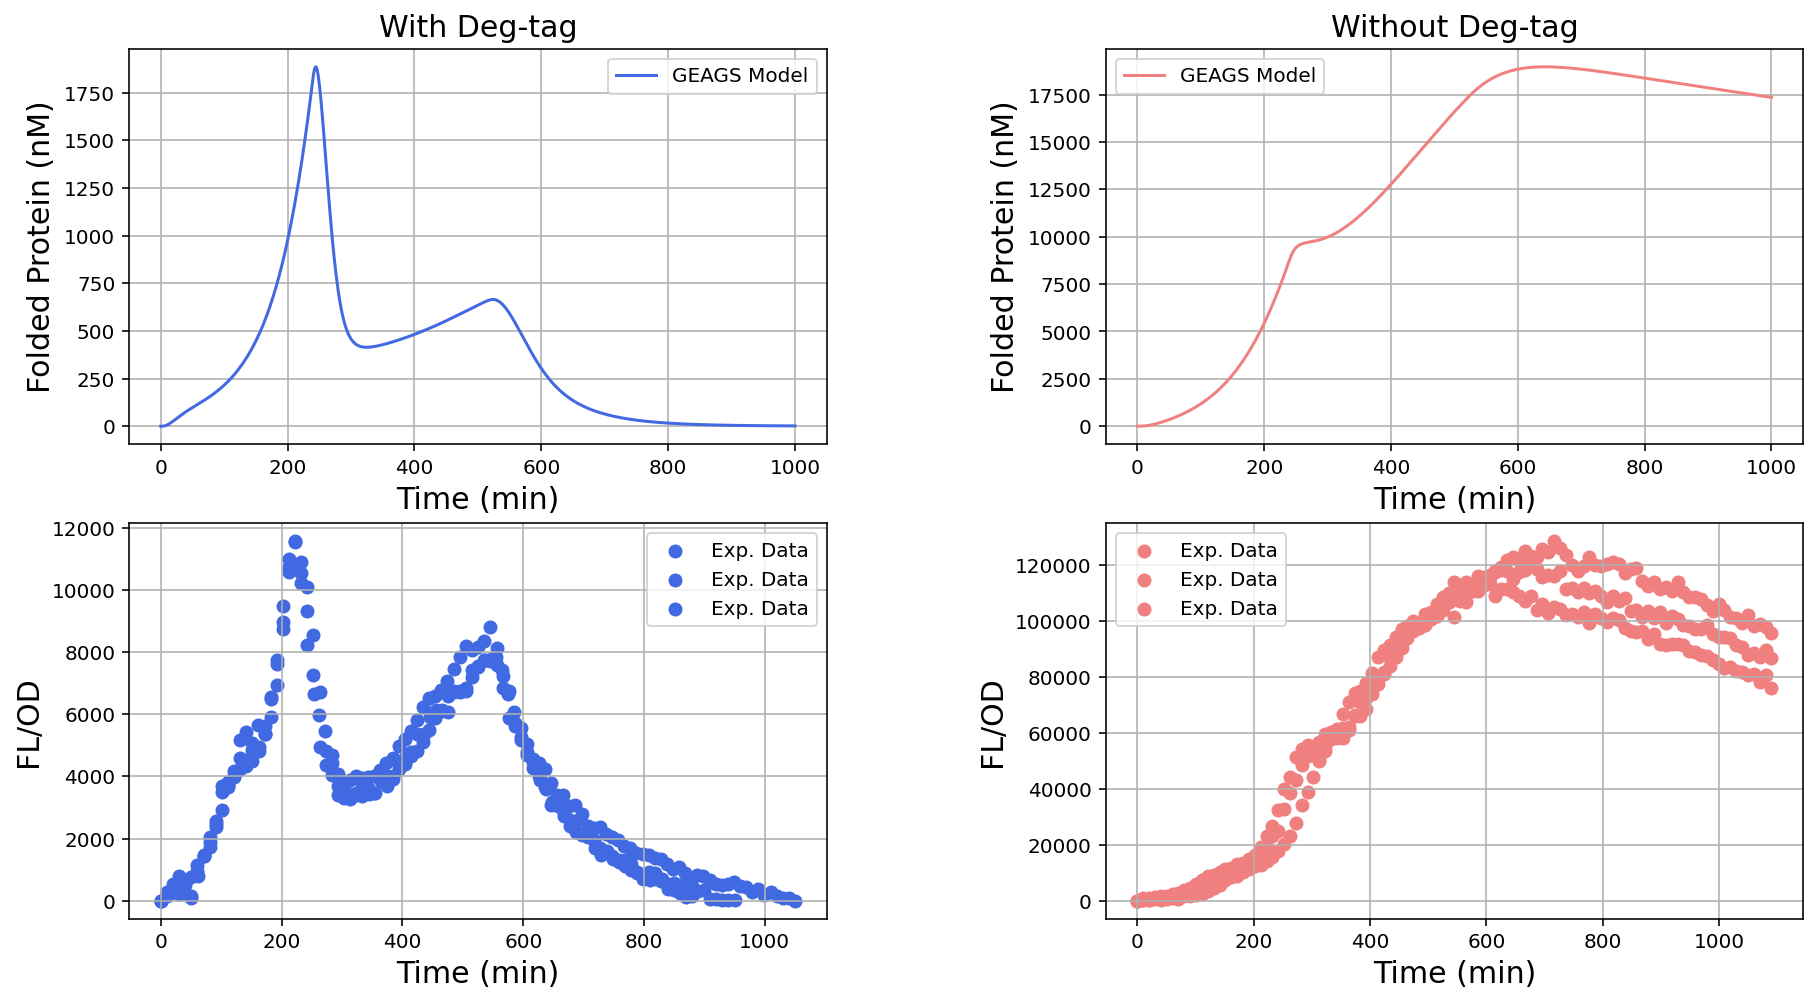

In [138]:
fig, ax = plt.subplots(2,2, figsize = (15,8))
fig.subplots_adjust(wspace = 0.4)#, hspace = 0.1)

r,c = 0,0
ax[r,c].plot(timepoints, sol_deg['protein_X'], label = "GEAGS Model", color = 'royalblue')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('Folded Protein (nM)', fontsize = 15) 
ax[r,c].set_title('With Deg-tag', fontsize = 15) ; ax[r,c].grid(True) ; ax[r,c].legend()

r,c = 0,1
ax[r,c].plot(timepoints, sol_no_deg['protein_X'], label = "GEAGS Model", color = 'lightcoral')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('Folded Protein (nM)', fontsize = 15) 
ax[r,c].set_title('Without Deg-tag', fontsize = 15) ; ax[r,c].grid(True) ; ax[r,c].legend()

r,c = 1,0
ax[r,c].scatter(time12, A1_non_leaky, color = 'royalblue', label = 'Exp. Data')
ax[r,c].scatter(time22, A2_non_leaky, color = 'royalblue', label = 'Exp. Data')
ax[r,c].scatter(time32, A3_non_leaky, color = 'royalblue', label = 'Exp. Data')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('FL/OD', fontsize = 15) ; ax[r,c].legend()
#ax[r,c].set_title('With Deg-tag') ; 
ax[r,c].grid(True)

r,c = 1,1
ax[r,c].scatter(timeB12, B1_non_leaky, color = 'lightcoral', label = 'Exp. Data')
ax[r,c].scatter(timeB22, B2_non_leaky, color = 'lightcoral', label = 'Exp. Data')
ax[r,c].scatter(timeB32, B3_non_leaky, color = 'lightcoral', label = 'Exp. Data')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('FL/OD', fontsize = 15) ; ax[r,c].legend()
#ax[r,c].set_title('Without Deg-tag') ; 
ax[r,c].grid(True)

In [139]:
# Import OLD CRN run data for comparison 

sol_deg_data_old_CRN = pd.read_csv('simulation_run_data_720min_deg_tag_112624.csv')
sol_no_deg_data_old_CRN = pd.read_csv('simulation_run_data_720min_no_deg_tag_112624.csv')
sol_deg_old_CRN = sol_deg_data_old_CRN['Folded_protein']
sol_no_deg_old_CRN = sol_no_deg_data_old_CRN['Folded_protein']
time_old_CRN = sol_no_deg_data_old_CRN['Time'].to_numpy()

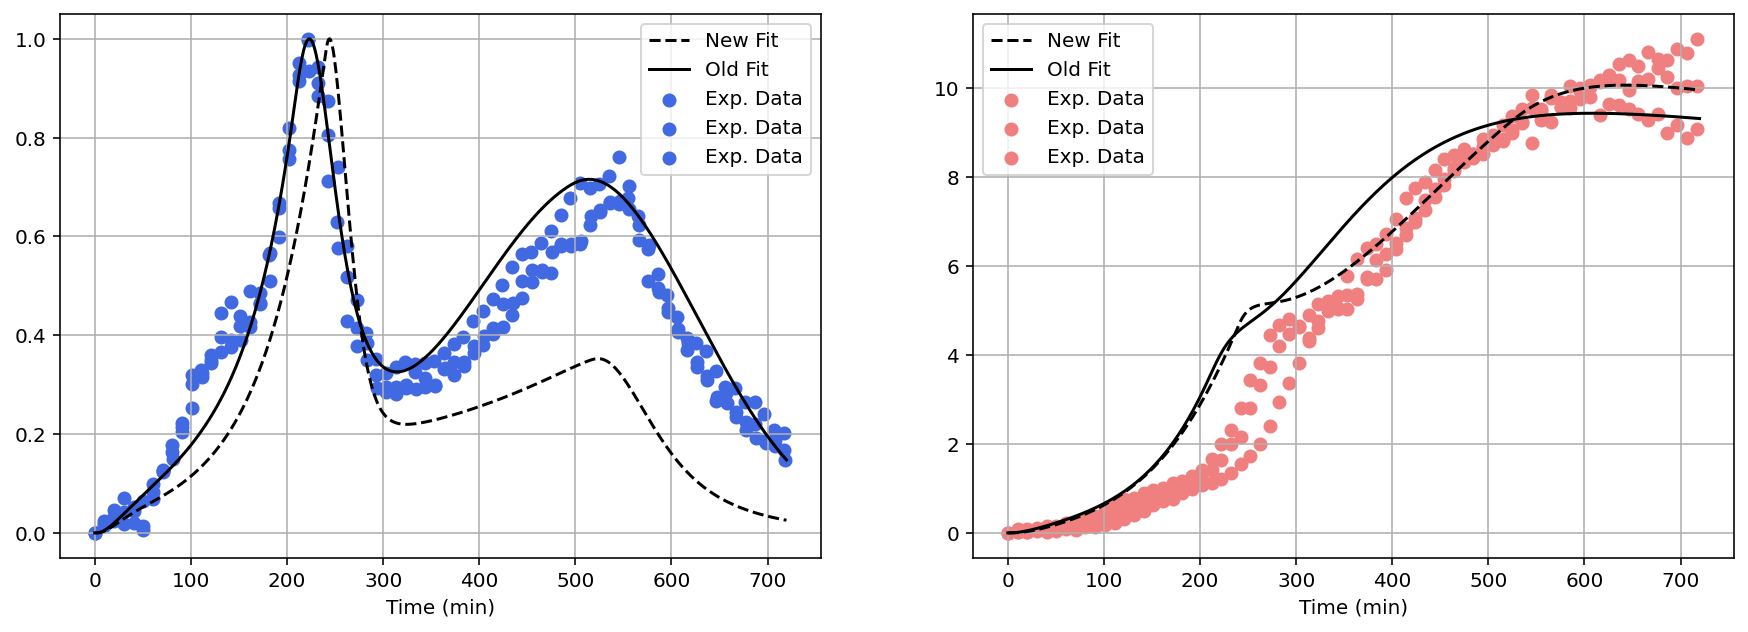

In [140]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
#fig, ax = plt.subplots(2,1, figsize = (8,12))

ax[0].plot(timepoints[:tf_I], sol_deg['protein_X'][:tf_I]/np.max(sol_deg_old_CRN), '--', label = "New Fit", color = 'black')
ax[0].plot(time_old_CRN, sol_deg_old_CRN/np.max(sol_deg_old_CRN), label = "Old Fit", color = 'black')
ax[0].scatter(time12[:tf_i], A1_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'royalblue', label = 'Exp. Data')
ax[0].scatter(time22[:tf_i], A2_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'royalblue', label = 'Exp. Data')
ax[0].scatter(time32[:tf_i], A3_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'royalblue', label = 'Exp. Data')
ax[0].set_xlabel('Time (min)'); ax[0].grid(True) ; ax[0].legend()

ax[1].plot(timepoints[:tf_I], sol_no_deg['protein_X'][:tf_I]/np.max(sol_deg_old_CRN), '--', label = "New Fit", color = 'black')
ax[1].plot(time_old_CRN, sol_no_deg_old_CRN/np.max(sol_deg_old_CRN), label = "Old Fit", color = 'black')
ax[1].scatter(timeB12[:tf_i], B1_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'lightcoral', label = 'Exp. Data')
ax[1].scatter(timeB22[:tf_i], B2_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'lightcoral', label = 'Exp. Data')
ax[1].scatter(timeB32[:tf_i], B3_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'lightcoral', label = 'Exp. Data')
ax[1].set_xlabel('Time (min)'); ax[1].grid(True) ; ax[1].legend()

In [141]:
np.max(sol_no_deg['protein_X'])/np.max(sol_deg['protein_X'])

10.057075056832579

In [142]:
def error_func(param, model_degtag, model_no_tag, *args, **kws):

    

    sol_deg_1, sol_no_deg_1 = run_CRN_model(param, model_degtag, model_no_tag, timepoints = time12)
    sol_deg_2, sol_no_deg_2 = run_CRN_model(param, model_degtag, model_no_tag, timepoints = time22)
    sol_deg_3, sol_no_deg_3 = run_CRN_model(param, model_degtag, model_no_tag, timepoints = time32)

    sol_deg_avg_max = np.mean((np.max(sol_deg_1['protein_X']),np.max(sol_deg_2['protein_X']),np.max(sol_deg_3['protein_X'])))
    sol_no_deg_avg_max = np.mean((np.max(sol_no_deg_1['protein_X']),np.max(sol_no_deg_2['protein_X']),np.max(sol_no_deg_3['protein_X'])))


    scaled_protein_1 = sol_deg_1['protein_X']/sol_deg_avg_max
    exp_A1 = A1_non_leaky.reshape((len(A1_non_leaky),))
    e1 = (scaled_protein_1 - exp_A1/np.max(A_avg))**2
    

    scaled_protein_2 = sol_deg_2['protein_X']/sol_deg_avg_max
    exp_A2 = A2_non_leaky.reshape((len(A2_non_leaky),))
    e2 = (scaled_protein_2 - exp_A2/np.max(A_avg))**2
    

    scaled_protein_3 = sol_deg_3['protein_X']/sol_deg_avg_max
    exp_A3 = A3_non_leaky.reshape((len(A3_non_leaky),))
    e3 = (scaled_protein_3 - exp_A3/np.max(A_avg))**2
    

    e4 = ((np.max(sol_no_deg_1['protein_X'])/np.max(sol_deg_1['protein_X'])) - avg_fold_change)**2
    e5 = ((np.max(sol_no_deg_2['protein_X'])/np.max(sol_deg_2['protein_X'])) - avg_fold_change)**2
    e6 = ((np.max(sol_no_deg_3['protein_X'])/np.max(sol_deg_3['protein_X'])) - avg_fold_change)**2

    sol_deg_crn, sol_no_deg_crn = run_CRN_model(param, model_degtag, model_no_tag, timepoints = time_old_CRN)
    err_deg = ((sol_deg_crn['protein_X'] - sol_deg_old_CRN)/np.max(sol_deg_old_CRN))**2
 

    e = np.sum(e1) + np.sum(e2) + np.sum(e3) + np.sum(e4) + np.sum(e5) + np.sum(e6)
    e += np.sum(err_deg) # to fit the new model close to the old one. Optional, can be removed.
    
    return e

In [144]:
def callback(params, iter, resid, *args, **kws):
    """Call back function to save the objective function values in each iteration"""
    itervalues = kws['itervalues']
    itervalues.append(resid)

itervalues = []

# # options = {'method' : 'nelder'}
# results = lmfit.minimize(error_func, params, args = (model_degtag, model_no_tag), method = 'basinhopping')#, 
#                          #initial_temp  = 8000)#, minimizer_kwargs = options)
options_dict = {'adapt' : True}
results = lmfit.minimize(error_func, params, args = (model_degtag, model_no_tag), method = 'nelder',
                          options = {'adaptive' : False}, iter_cb = callback, kws = {'itervalues':itervalues})
results

/Users/harikrishnan/.local/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


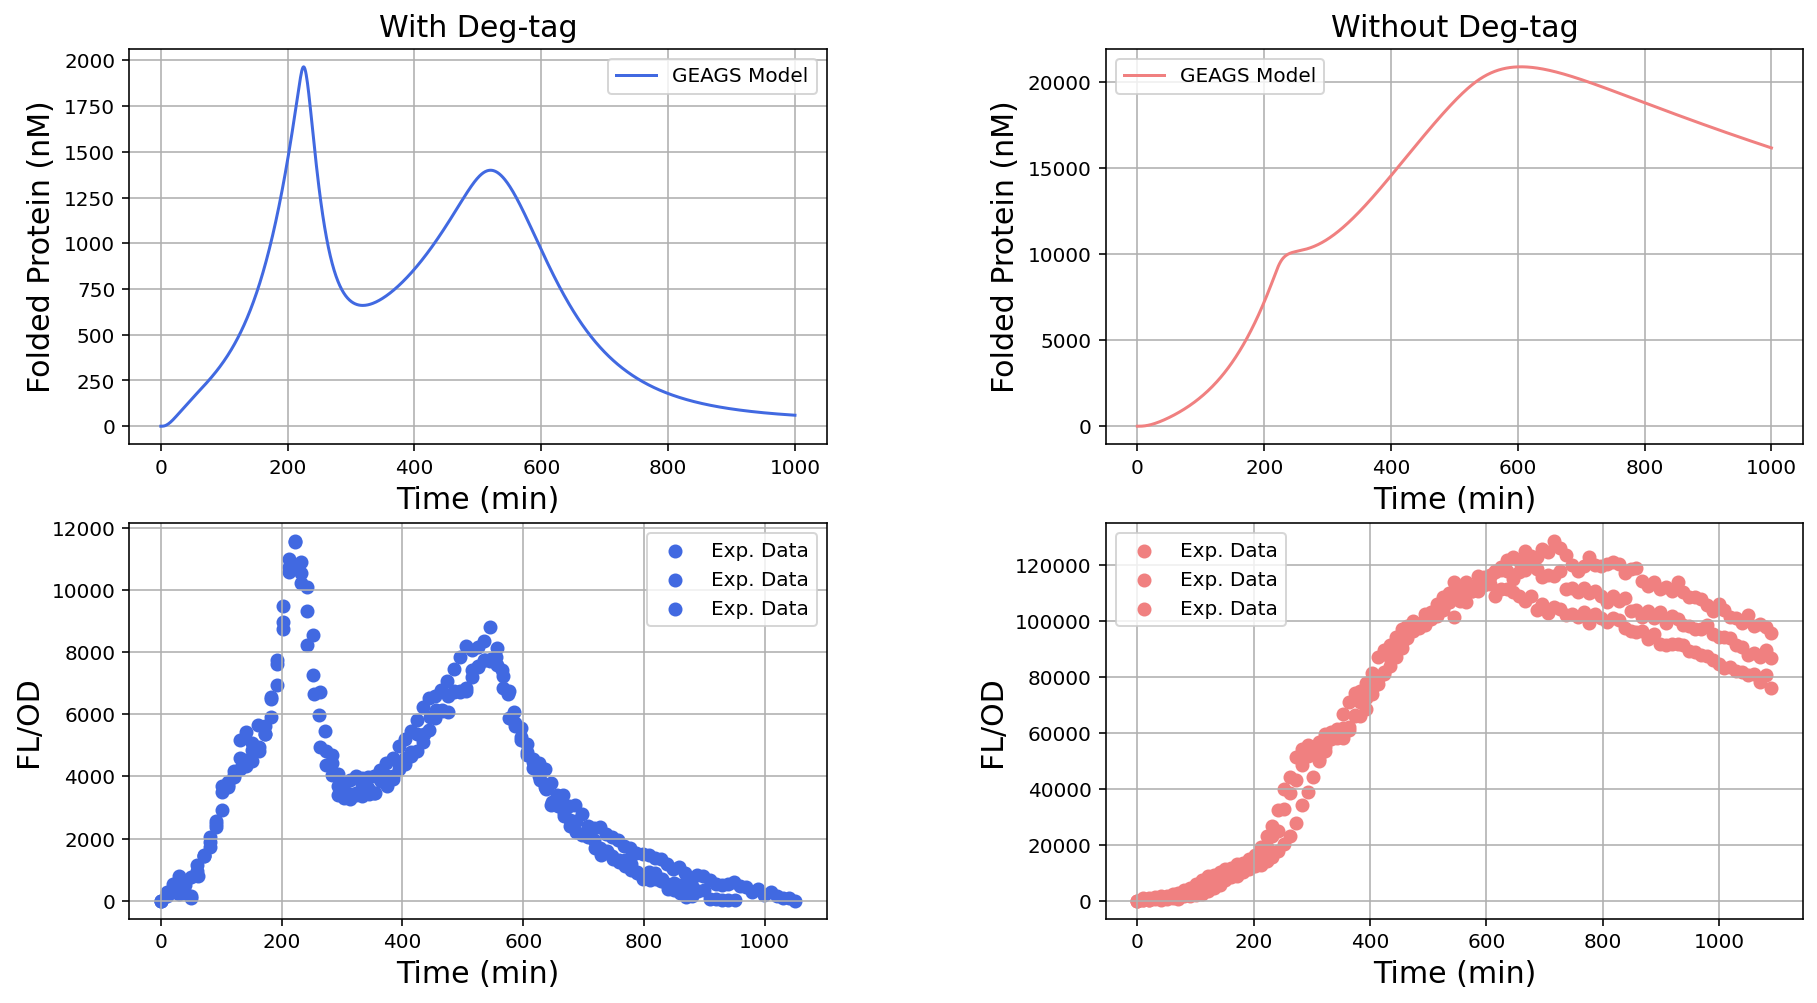

In [145]:
param_fit = results.params

sol_deg, sol_no_deg = run_CRN_model(param_fit, model_degtag, model_no_tag, timepoints)

fig, ax = plt.subplots(2,2, figsize = (15,8))
fig.subplots_adjust(wspace = 0.4)#, hspace = 0.1)

r,c = 0,0
ax[r,c].plot(timepoints, sol_deg['protein_X'], label = "GEAGS Model", color = 'royalblue')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('Folded Protein (nM)', fontsize = 15) 
ax[r,c].set_title('With Deg-tag', fontsize = 15) ; ax[r,c].grid(True) ; ax[r,c].legend()

r,c = 0,1
ax[r,c].plot(timepoints, sol_no_deg['protein_X'], label = "GEAGS Model", color = 'lightcoral')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('Folded Protein (nM)', fontsize = 15) 
ax[r,c].set_title('Without Deg-tag', fontsize = 15) ; ax[r,c].grid(True) ; ax[r,c].legend()

r,c = 1,0
ax[r,c].scatter(time12, A1_non_leaky, color = 'royalblue', label = 'Exp. Data')
ax[r,c].scatter(time22, A2_non_leaky, color = 'royalblue', label = 'Exp. Data')
ax[r,c].scatter(time32, A3_non_leaky, color = 'royalblue', label = 'Exp. Data')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('FL/OD', fontsize = 15) ; ax[r,c].legend()
#ax[r,c].set_title('With Deg-tag') ; 
ax[r,c].grid(True)

r,c = 1,1
ax[r,c].scatter(timeB12, B1_non_leaky, color = 'lightcoral', label = 'Exp. Data')
ax[r,c].scatter(timeB22, B2_non_leaky, color = 'lightcoral', label = 'Exp. Data')
ax[r,c].scatter(timeB32, B3_non_leaky, color = 'lightcoral', label = 'Exp. Data')
ax[r,c].set_xlabel('Time (min)', fontsize = 15) ; ax[r,c].set_ylabel('FL/OD', fontsize = 15) ; ax[r,c].legend()
#ax[r,c].set_title('Without Deg-tag') ; 
ax[r,c].grid(True)

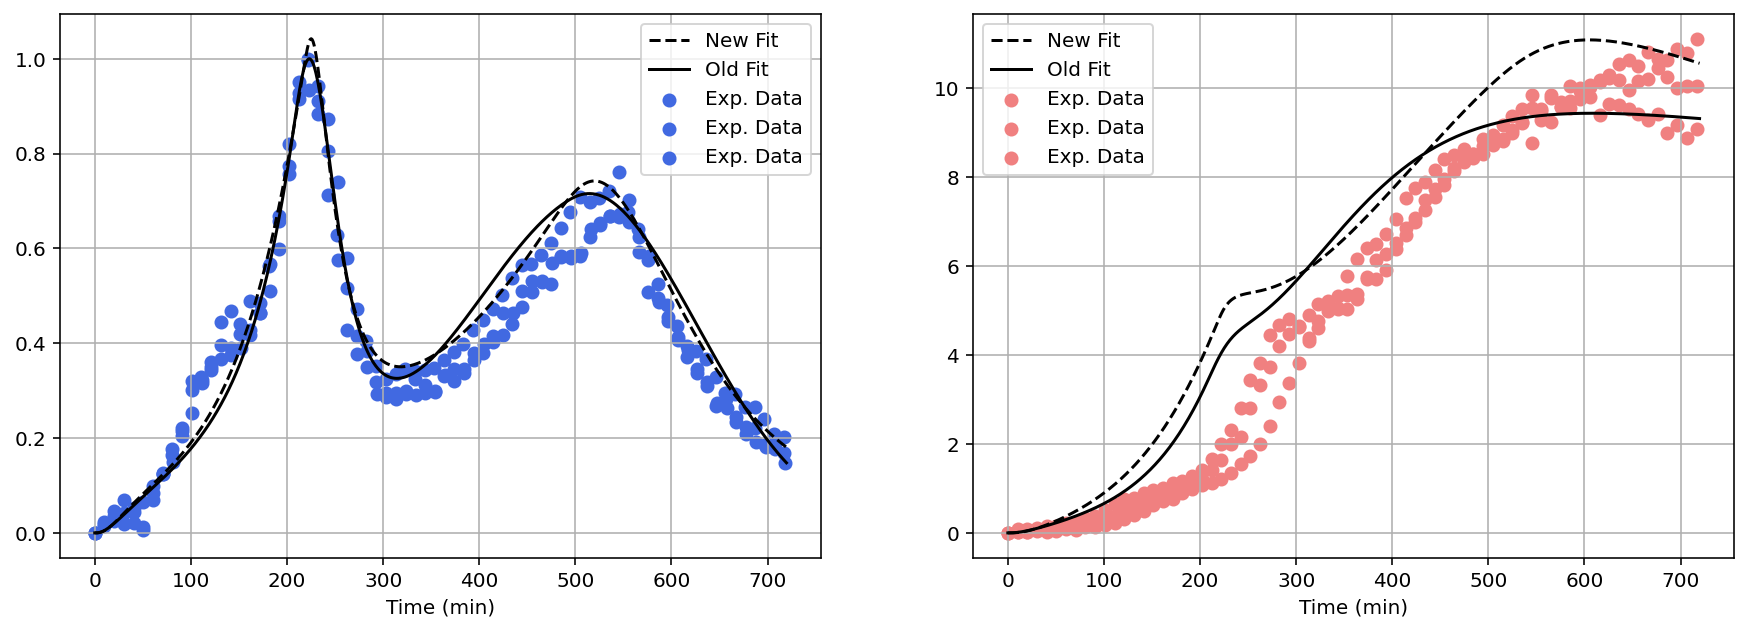

In [146]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
#fig, ax = plt.subplots(2,1, figsize = (8,12))

ax[0].plot(timepoints[:tf_I], sol_deg['protein_X'][:tf_I]/np.max(sol_deg_old_CRN), '--', label = "New Fit", color = 'black')
ax[0].plot(time_old_CRN, sol_deg_old_CRN/np.max(sol_deg_old_CRN), label = "Old Fit", color = 'black')
ax[0].scatter(time12[:tf_i], A1_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'royalblue', label = 'Exp. Data')
ax[0].scatter(time22[:tf_i], A2_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'royalblue', label = 'Exp. Data')
ax[0].scatter(time32[:tf_i], A3_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'royalblue', label = 'Exp. Data')
ax[0].set_xlabel('Time (min)'); ax[0].grid(True) ; ax[0].legend()

ax[1].plot(timepoints[:tf_I], sol_no_deg['protein_X'][:tf_I]/np.max(sol_deg_old_CRN), '--', label = "New Fit", color = 'black')
ax[1].plot(time_old_CRN, sol_no_deg_old_CRN/np.max(sol_deg_old_CRN), label = "Old Fit", color = 'black')
ax[1].scatter(timeB12[:tf_i], B1_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'lightcoral', label = 'Exp. Data')
ax[1].scatter(timeB22[:tf_i], B2_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'lightcoral', label = 'Exp. Data')
ax[1].scatter(timeB32[:tf_i], B3_non_leaky[:tf_i]/np.max(A3_non_leaky), color = 'lightcoral', label = 'Exp. Data')
ax[1].set_xlabel('Time (min)'); ax[1].grid(True) ; ax[1].legend()

In [147]:
np.max(sol_no_deg['protein_X'])/np.max(sol_deg['protein_X'])

10.626456505732254

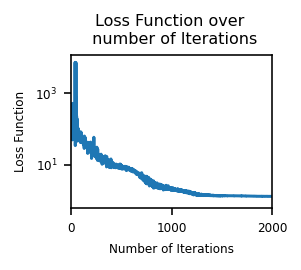

In [159]:
n_iters = range(len(itervalues))
plt.figure(figsize = (1.8, 1.4))
plt.plot(n_iters, itervalues)
plt.yscale('log')
plt.xlim((0, 2000))
#plt.ylim((0,500))
plt.xlabel('Number of Iterations', fontsize = 6)
plt.ylabel('Loss Function', fontsize = 6)
plt.xticks(fontsize = 6) ; plt.yticks(fontsize = 6)
plt.title('Loss Function over \n number of Iterations', fontsize = 8)
# plt.savefig('Loss_function_niter.svg', dpi = 300)

In [149]:
param_dict = param_fit.valuesdict()
# param_dict_guess_df = dict()
# param_dict_guess_df['Param name'] = param_dict.keys()
# param_dict_guess_df['Param'] = param_dict.values()
# param_data = pd.DataFrame(data = param_dict_guess_df)
# param_data.to_csv('params_best_fit_030425_v2.csv')
param_dict

{'n_gamma_RNAP': 0.18093241988481604,
 'n_gamma_Et': 0.36778255330274107,
 'n_gamma_tRNA': 0.6849757599139311,
 'n_gamma_Ribo': 0.8402864085126661,
 'n_gamma_Protease': 0.39553905494252845,
 'Sigma_IC': 168.77027386365825,
 'NT_IC': 668.6602137103439,
 'RNAase_IC': 95.08178136852916,
 'AA_IC': 73516.38823258688,
 'Ribo_max': 414.4043359665581,
 'tRNA_max': 1326.1544589002633,
 'RNAP_max': 1611.5885394916281,
 'Et_max': 743.6349676089156,
 'Protease_max': 997.3063170135139,
 'k_tx_1b': 0.055072883683777274,
 'k_tx_1u': 11.951015233357186,
 'k_tx_2b': 0.0016649529115748782,
 'k_tx_2u': 0.09665165514307804,
 'k_tx_3': 0.0034254120145522852,
 'k_tx_4b': 2.042366638205863,
 'k_tx_4u': 169.511988857639,
 'k_tx_5': 0.4303253749884539,
 'k_tl_1b': 0.0010016782087311797,
 'k_tl_1u': 394.7094867006149,
 'k_tl_2u': 129.3884584919386,
 'k_tl_2b': 9.273434904062682,
 'k_tl_3b': 0.04375306293214723,
 'k_tl_3u': 11.468535890481535,
 'k_tl_4': 0.1679901057200325,
 'k_tl_5': 0.10029567991522859,
 'b_tl

In [150]:
# import os
# os.system('spd-say "your program has finished"')